# Approximate search for LDA

In this notebook, we attempt to implement the full polynomial time approximation scheme for the less discriminatory alternative.

To do so, we must first implement the "value-based" (in other words, "disparity-based") pseudo-polynomial algorithm.

This algorithm cycles through disparity values (rather than utility values). Starting from $|d(h^*)|$, and incrementing down to 0, the algorithm computes the least necessary utility budget needed to reach the given disparity value, for a given subset of datapoints $i$.

To calculate the sub-problems, we have to specify a recursion. Notice that, each time we consider a new element $\{i\}$, the minimum utility budget needed is $B(i-1, d)$ if the element should not be added. If $u(i) < B(i-1, d)$ and $|D(i)|\leq d$, then the new element should be added. If it is the only element that should be added, $B(i,d) = u(i)$. Otherwise, if it should be added to a group of data points, then $B(i,d) = u(i) + B(i-1,d-D(i))$. Thus we have a recursion specified by:

$B(i,d) = min[B(i-1,d), u_i, u_i + B(i-1,d-d_i)]$

Three quantities:
1. $B(i,d)$ --> The minimum utility budget needed to achieve disparity at most d for the subset of points {1,...,i}.
2. $u_i + B(i-1,min(d_{max},d+d_i))$ --> The minimum utility needed to achieve d by including d_i
3. $B(i-1,d)$ --> The minimum utility needed to achieve d by not including d_i

The condition to see if $i$ should be the only variable included: Just take the max over the $d+d_i$ and the starting position!

So the function should look like this:
Solve the optimal classifier
Turn all rational numbers into integers
Start $d$ at the disparity value of the optimal classifier.
Start i at 1.
Notice that, in order to achieve the disparity of the optimal classifier (i.e., the worst disparity), the amount of utility budget you need is 0. 
So fill in 0's for all rows where d=d_max.
Now, as we decrement the disparity, we need a way to know whether it is possible to acheive the given disparity value with the subset of data. We can do this by checking the two options: notice we can't go beyond 

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import psutil
import random
import time

In [2]:
def gcd_rational(list_of_numbers):
    num_decimals = 0
    for n in list_of_numbers:
        if "." in str(n):
            num=round(n,12)
            num_decimals = np.max([num_decimals, len(str(num).split(".")[1])])
    decimal_multiplier = np.prod(np.array([10]*num_decimals))
    list_of_numbers_manipulated = decimal_multiplier*list_of_numbers
    return np.gcd.reduce([round(i) for i in list_of_numbers_manipulated])/(decimal_multiplier)

In [3]:
def dynamic_program_dbased(change_in_d, change_in_u,
                           #d_range,
                           U_budget, D_h_0,D_h_opt):
    
    #Dynamic program...
    max_change_in_d = D_h_opt
    min_change_in_d = D_h_opt
    for i in change_in_d:
        if i<0:
            min_change_in_d=min_change_in_d+i
        else:
            max_change_in_d = max_change_in_d+i
    d_range = list(range(min_change_in_d,max_change_in_d,1))#+1))  #NOTE THIS WAS JUST ADDED AFTER THE FACT AS QUICK-FIX
    
    n_data = len(change_in_d)
    
    df = pd.DataFrame(columns=range(len(d_range)+3)) #NOTE THIS WAS JUST ADDED AFTER THE FACT AS QUICK-FIX
    df.iloc[:,0]=pd.Series([0]*(n_data+1),index=range(n_data+1))
    df.iloc[0,1:]=np.infty

    for i in range(1,n_data+1):
        for disp in range(1,len(d_range)):
            if disp+change_in_d[i-1]<0 or disp+change_in_d[i-1]>len(d_range): #(change_in_d[i-1]+d_range[disp]<min_change_in_d) or (change_in_d[i-1]+d_range[disp]>max_change_in_d):
                df.loc[i,disp]=df.loc[i-1,disp]
            else:
                quantity1 = df.iloc[i-1,disp]
                if -change_in_d[i-1]==disp: #if the change in disparity is achieved with the new datapoint alone
                    quantity2 = np.min(np.array([-change_in_u[i-1],-change_in_u[i-1] + df.iloc[i-1,change_in_d[i-1]+disp]]))
                else:
                    quantity2 = -change_in_u[i-1] + df.iloc[i-1,change_in_d[i-1]+disp]
                #print("quantity1: ",quantity1)
                #print("quantity2: ",quantity2)
                df.iloc[i,disp] = np.min(np.array([quantity1,quantity2]))

    if D_h_0==0:
        print("NOTE: Starting disparity of 0. Value of D_h_0: ",D_h_0)
        print("NO LDA EXISTS.")
        return None
    if D_h_0 <0:
        print("NOTE: Starting disparity negative. Value of D_h_0: ",D_h_0)
        ranger = range(0,D_h_0,-1)
    else:
        ranger=range(D_h_0)
    
    #Now find the minimum-disparity classifier with utility budget below U_h_0
    zero_disparity_index = list(ranger).index(0)#+1 ####ADDED AS BANDAID
        
    for d in ranger:
        u_cost_1 = df.iloc[n_data,zero_disparity_index+d]
        u_cost_2 = df.iloc[n_data,zero_disparity_index-d]

        if (u_cost_1<U_budget) and (u_cost_1<u_cost_2):
            #print("LDA disparity performance: ", round(gcd*(zero_disparity_index+d),12))
            print("LDA disparity performance before rebase: ", (zero_disparity_index+d))
            #print("LDA utility performance: ", round(gcd*u_cost_1),12)
            print("LDA utility performance before rebase: ", u_cost_1)
            min_disparity_index = zero_disparity_index+d
            utility_budget_value = u_cost_1
            break
        elif (u_cost_2<U_budget) and (u_cost_2<u_cost_1):
            #print("LDA disparity performance: ", round(gcd*(zero_disparity_index-d),12))
            #print("LDA utility performance: ", round(gcd*u_cost_2,12))
            print("LDA disparity performance before rebase: ", (zero_disparity_index-d))
            print("LDA utility performance before rebase: ", u_cost_2)
            min_disparity_index = zero_disparity_index-d
            utility_budget_value = u_cost_2
            break
        if d==list(ranger)[-1]:
            print("NO LDA EXISTS.")
            return None

    #Now determine which values must be switched
    switch_list = np.array([0]*n_data)
    util_var = np.min([u_cost_1,u_cost_2])#utility_budget_value
    disp_var = min_disparity_index
    i=n_data
    while i>0:
        while i>0 and util_var == df.iloc[i-1,disp_var]:
            i=i-1
        if i>0 and disp_var>0:
            switch_list[i-1]=1
            disp_var=disp_var+change_in_d[i-1]
        i=i-1
    switch_list=np.array(switch_list)
    #result_classifier = np.abs(np.subtract(h_opt,switch_list))
    return switch_list#result_classifier

In [4]:
def LDA(rho_1,rho_2,sigma,h_0,lamb):
    u = 0.5*(rho_1+rho_2)*(sigma-lamb*(1-sigma))
    d = np.subtract(rho_1,rho_2)
    h_opt = [1 if sigma[i]>(lamb/(1+lamb)) else 0 for i in range(len(sigma))]
    change_in_d_before_manip = d-2*(h_opt*d)
    change_in_u_before_manip = u-2*(h_opt*u)
    gcd = gcd_rational(np.abs(np.array(list(change_in_d_before_manip)+list(change_in_u_before_manip))))
    if np.round(gcd_rational(np.abs(np.array(list(change_in_d_before_manip)+list(change_in_u_before_manip)))),10)==0:
        print("ERROR: ROUNDED GCD IS 0")
        print("gcd: ",gcd)
        print("rounded GCD: ",np.round(gcd_rational(np.abs(np.array(list(change_in_d_before_manip)+list(change_in_u_before_manip)))),8))
    else:
        gcd=np.round(gcd_rational(np.abs(np.array(list(change_in_d_before_manip)+list(change_in_u_before_manip)))),8)
    print("gcd: ",gcd)
    change_in_d = np.array([int(round(i/gcd)) for i in change_in_d_before_manip])
    change_in_u = np.array([int(round(i/gcd)) for i in change_in_u_before_manip])#change_in_u/gcd
    U_h_0 = int(round(np.dot(u, h_0) / gcd))

    D_h_0 = int(round(np.divide(np.dot(d, h_0),gcd))) #D_h_0 = int(round(np.abs(np.dot(d, h_0))/gcd))
    print("D_h_0: ",D_h_0)
    U_h_opt = int(round(np.dot(u,h_opt) / gcd))
    D_h_opt = int(round(np.dot(d, h_opt)/gcd)) #D_h_opt = int(round(np.abs(np.dot(d, h_opt))/gcd))
    U_budget = U_h_opt-U_h_0
    n_data = len(h_0)
    
    ##Dynamic program...
    #max_change_in_d = D_h_opt
    #min_change_in_d = D_h_opt
    #for i in change_in_d:
    #    if i<0:
    #        min_change_in_d=min_change_in_d+i
    #    else:
    #        max_change_in_d = max_change_in_d+i
    #d_range = list(range(min_change_in_d,max_change_in_d+1))

    #print("change_in_d: ",change_in_d)
    #print("change_in_u: ",change_in_u)
    #print("d_range: ",d_range)
    #print("U_budget: ",U_budget)
    #print("D_h_0: ",D_h_0)
    switch_list = dynamic_program_dbased(change_in_d, change_in_u, 
                                         #d_range,
                                         U_budget, D_h_0,D_h_opt)
    if switch_list is None:
        return h_0
    result_classifier = np.abs(np.subtract(h_opt,switch_list))
    return result_classifier

    #df = pd.DataFrame(columns=range(len(d_range)))
    #df.iloc[:,0]=pd.Series([0]*(n_data+1),index=range(n_data+1))
    #df.iloc[0,1:]=np.infty

    #for i in range(1,n_data+1):
    #    for disp in range(1,len(d_range)):
    #        if disp+change_in_d[i-1]<0 or disp+change_in_d[i-1]>len(d_range): #(change_in_d[i-1]+d_range[disp]<min_change_in_d) or (change_in_d[i-1]+d_range[disp]>max_change_in_d):
    #            df.loc[i,disp]=df.loc[i-1,disp]
    #        else:
    #            quantity1 = df.iloc[i-1,disp]
    #            if -change_in_d[i-1]==disp: #if the change in disparity is achieved with the new datapoint alone
    #                quantity2 = np.min(np.array([-change_in_u[i-1],-change_in_u[i-1] + df.iloc[i-1,change_in_d[i-1]+disp]]))
    #            else:
    #                quantity2 = -change_in_u[i-1] + df.iloc[i-1,change_in_d[i-1]+disp]
    #            #print("quantity1: ",quantity1)
    #            #print("quantity2: ",quantity2)
    #            df.iloc[i,disp] = np.min(np.array([quantity1,quantity2]))

    ##Now find the minimum-disparity classifier with utility budget below U_h_0
    #zero_disparity_index = d_range.index(0)
    #for d in range(D_h_0):
    #    u_cost_1 = df.iloc[n_data,zero_disparity_index+d]
    #    u_cost_2 = df.iloc[n_data,zero_disparity_index-d]

    #    if (u_cost_1<U_budget) and (u_cost_1<u_cost_2):
    #        print("LDA disparity performance: ", round(gcd*(zero_disparity_index+d),8))
    #        print("LDA utility performance: ", round(gcd*u_cost_1),8)
    #        min_disparity_index = zero_disparity_index+d
    #        utility_budget_value = u_cost_1
    #    elif (u_cost_2<U_budget) and (u_cost_2<u_cost_1):
    #        print("LDA disparity performance: ", round(gcd*(zero_disparity_index-d),8))
    #        print("LDA utility performance: ", round(gcd*u_cost_2,8))
    #        min_disparity_index = zero_disparity_index-d
    #        utility_budget_value = u_cost_2

    ##Now determine which values must be switched
    #switch_list = np.array([0]*n_data)
    #util_var = utility_budget_value
    #disp_var = min_disparity_index
    #i=n_data
    #while i>0:
    #    while util_var == df.iloc[i-1,disp_var]:
    #        i=i-1
    #    if i>0 and disp_var>0:
    #        switch_list[i-1]=1
    #        disp_var=disp_var+change_in_d[i-1]
    #    i=i-1
    #switch_list=np.array(switch_list)
    #result_classifier = np.abs(np.subtract(h_opt,switch_list))
    #return result_classifier

In [5]:
def LDA_approx(epsilon,rho_1,rho_2,sigma,h_0,lamb):
    
    #First, do all the preliminary steps to find the range in disparity value
    u = 0.5*(rho_1+rho_2)*(sigma-lamb*(1-sigma))
    d = rho_1-rho_2
    h_opt = [1 if sigma[i]>(lamb/(1+lamb)) else 0 for i in range(len(sigma))]
    change_in_d_before_manip = d-2*(h_opt*d)
    print("change_in_d_before_manip: ",change_in_d_before_manip)
    change_in_u_before_manip = u-2*(h_opt*u)
    print("change_in_u_before_manip: ",change_in_u_before_manip)
    gcd = gcd_rational(np.abs(np.array(list(change_in_d_before_manip)+list(change_in_u_before_manip))))
    print("gcd in approx: ",gcd)
    change_in_d = np.array([int(round(i/gcd)) for i in change_in_d_before_manip])
    print("change_in_d: ",change_in_d)
    change_in_u = np.array([int(round(i/gcd)) for i in change_in_u_before_manip])#change_in_u/gcd
    print("change_in_u: ",change_in_u)
    U_h_0 = int(round(np.dot(u, h_0) / gcd))
    print("U_h_0: ",U_h_0)
    D_h_0 = int(round(np.dot(d, h_0)/gcd)) #D_h_0 = int(round(np.abs(np.dot(d, h_0))/gcd))
    print("D_h_0: ",D_h_0)
    U_h_opt = int(round(np.dot(u,h_opt) / gcd))
    D_h_opt = int(round(np.dot(d, h_opt)/gcd)) #D_h_opt = int(round(np.abs(np.dot(d, h_opt))/gcd))
    U_budget = U_h_opt-U_h_0
    print("U_budget: ",U_budget)
    n_data = len(h_0)
    print("n_data: ",n_data)
    max_change_in_d = D_h_opt
    min_change_in_d = D_h_opt
    for i in change_in_d:
        if i<0:
            min_change_in_d=min_change_in_d+i
        else:
            max_change_in_d = max_change_in_d+i
    d_range = list(range(min_change_in_d,max_change_in_d+1))
    print("length of d_range: ",len(d_range))

    #epsilon_manip = epsilon/len(d_range)
    #b = round((epsilon/(2*n_data))*len(d_range),12)
    b = round(epsilon/(2*n_data),12)
    print("b MANIP: ",b)
    
    #change_in_d_approx = [int(i) for i in np.round(np.divide(change_in_d,b))]
    #change_in_u_approx = [int(i) for i in np.round(np.divide(change_in_u,b))]
    #d_range_approx = [int(i) for i in np.round(np.divide(d_range,b))]
    #U_budget_approx = int(np.round(np.divide(U_budget,b)))
    #D_h_0_approx = int(np.round(np.divide(D_h_0,b)))
    #print("change_in_d: ",change_in_d)
    #print("change_in_d_approx: ",change_in_d_approx)
    #return dynamic_program_dbased(change_in_d_approx, change_in_u_approx, d_range_approx, U_budget_approx, D_h_0_approx)
    
    rho_1_approx = np.ceil(np.divide(rho_1,b))*b#np.round(np.divide(rho_1,b))
    rho_2_approx = np.ceil(np.divide(rho_2,b))*b#np.round(np.divide(rho_2,b))
    #sigma_approx = np.round(np.divide(sigma,b))
    print("rho_1: ", rho_1)
    print("rho_1_approx: ", rho_1_approx)
    print("rho_2: ", rho_2)
    print("rho_2_approx: ", rho_2_approx)
    return LDA(rho_1_approx,rho_2_approx,sigma,h_0,lamb)



## An example

In [7]:
rho_1 = np.array([0.15,0.05,0.2,0.6])
rho_2 = np.array([0.3,0.3,0.3,0.1])
sigma = np.array([0,0.25,0.3,1])
h_0 = np.array([0,0,1,1])
lamb = 1
LDA_start = time.time()
LDA(rho_1,rho_2,sigma,h_0,lamb)
LDA_end = time.time()
print(LDA_end - LDA_start)

gcd:  0.0125
[0.15 0.05 0.2  0.6 ]
[0.3 0.3 0.3 0.1]
[-0.15 -0.25 -0.1   0.5 ]
[0 0 1 1]
0.0125
D_h_0:  32
LDA disparity performance before rebase:  20
LDA utility performance before rebase:  7.0
0.03970217704772949


In [8]:
approx_start = time.time()
LDA_approx(.0001,rho_1,rho_2,sigma,h_0,lamb)
approx_end = time.time()
print(approx_end - approx_start)

change_in_d_before_manip:  [-0.15 -0.25 -0.1  -0.5 ]
change_in_u_before_manip:  [-0.225  -0.0875 -0.1    -0.35  ]
gcd in approx:  0.0125
change_in_d:  [-12 -20  -8 -40]
change_in_u:  [-18  -7  -8 -28]
U_h_0:  20
D_h_0:  32
U_budget:  8
n_data:  4
length of d_range:  81
b MANIP:  1.25e-05
rho_1:  [0.15 0.05 0.2  0.6 ]
rho_1_approx:  [0.15 0.05 0.2  0.6 ]
rho_2:  [0.3 0.3 0.3 0.1]
rho_2_approx:  [0.3 0.3 0.3 0.1]
gcd:  0.0125
[0.15 0.05 0.2  0.6 ]
[0.3 0.3 0.3 0.1]
[-0.15 -0.25 -0.1   0.5 ]
[0 0 1 1]
0.0125
D_h_0:  32
LDA disparity performance before rebase:  20
LDA utility performance before rebase:  7.0
0.0436549186706543


$\epsilon$ is a factor of the optimal disparity level that we wish to be able to reach.
The rounding step we take for the sake of approximation occurs after converting the variables to integers.



In [9]:
u = 0.5*(rho_1+rho_2)*(sigma-lamb*(1-sigma))
d = rho_1-rho_2
h_opt = [1 if sigma[i]>(lamb/(1+lamb)) else 0 for i in range(len(sigma))]
change_in_d_before_manip = d-2*(h_opt*d)
change_in_u_before_manip = u-2*(h_opt*u)
gcd = gcd_rational(np.abs(np.array(list(change_in_d_before_manip)+list(change_in_u_before_manip))))
change_in_d = np.array([int(round(i/gcd)) for i in change_in_d_before_manip])
change_in_u = np.array([int(round(i/gcd)) for i in change_in_u_before_manip])#change_in_u/gcd
U_h_0 = int(round(np.dot(u, h_0) / gcd))
D_h_0 = int(round(np.dot(d, h_0)/gcd)) #D_h_0 = int(round(np.abs(np.dot(d, h_0))/gcd))
U_h_opt = int(round(np.dot(u,h_opt) / gcd))
D_h_opt = int(round(np.dot(d, h_opt)/gcd)) #D_h_opt = int(round(np.abs(np.dot(d, h_opt))/gcd))
U_budget = U_h_opt-U_h_0
n_data = len(h_0)
print("u: ",u)
print("d: ",d)
print("h_opt: ",h_opt)
print("gcd: ",gcd)
print("change_in_d: ",change_in_d)
print("change_in_u: ",change_in_u)
print("U_h_0: ",U_h_0)
print("D_h_0: ",D_h_0)
print("U_h_opt: ",U_h_opt)
print("D_h_opt: ",D_h_opt)




u:  [-0.225  -0.0875 -0.1     0.35  ]
d:  [-0.15 -0.25 -0.1   0.5 ]
h_opt:  [0, 0, 0, 1]
gcd:  0.0125
change_in_d:  [-12 -20  -8 -40]
change_in_u:  [-18  -7  -8 -28]
U_h_0:  20
D_h_0:  32
U_h_opt:  28
D_h_opt:  40


In [10]:
#Dynamic program...

max_change_in_d = D_h_opt
min_change_in_d = D_h_opt
for i in change_in_d:
    if i<0:
        min_change_in_d=min_change_in_d+i
    else:
        max_change_in_d = max_change_in_d+i
d_range = list(range(min_change_in_d,max_change_in_d+1))
print("max_change_in_d: ",max_change_in_d)
print("min_change_in_d: ",min_change_in_d)

df = pd.DataFrame(columns=range(len(d_range)))
df.iloc[:,0]=pd.Series([0]*(n_data+1),index=range(n_data+1))
df.iloc[0,1:]=np.infty

for i in range(1,n_data+1):
    for disp in range(1,len(d_range)):
        #print(i)
        #print(disp)
        #print(change_in_d[i-1])
        if disp+change_in_d[i-1]<0 or disp+change_in_d[i-1]>len(d_range): #(change_in_d[i-1]+d_range[disp]<min_change_in_d) or (change_in_d[i-1]+d_range[disp]>max_change_in_d):
            df.loc[i,disp]=df.loc[i-1,disp]
        else:
            quantity1 = df.iloc[i-1,disp]
            if -change_in_d[i-1]==disp: #if the change in disparity is achieved with the new datapoint alone
                quantity2 = np.min(np.array([-change_in_u[i-1],-change_in_u[i-1] + df.iloc[i-1,change_in_d[i-1]+disp]]))
            else:
                quantity2 = -change_in_u[i-1] + df.iloc[i-1,change_in_d[i-1]+disp]
            #print("quantity1: ",quantity1)
            #print("quantity2: ",quantity2)
            df.iloc[i,disp] = np.min(np.array([quantity1,quantity2]))
            
#Now find the minimum-disparity classifier with utility budget below U_h_0
zero_disparity_index = d_range.index(0)
for d in range(D_h_0):
    u_cost_1 = df.iloc[n_data,zero_disparity_index+d]
    u_cost_2 = df.iloc[n_data,zero_disparity_index-d]
    
    if (u_cost_1<U_budget) and (u_cost_1<u_cost_2):
        print("LDA disparity performance: ", zero_disparity_index+d)
        print("LDA utility performance: ", u_cost_1)
        min_disparity_index = zero_disparity_index+d
        utility_budget_value = u_cost_1
    elif (u_cost_2<U_budget) and (u_cost_2<u_cost_1):
        print("LDA disparity performance: ", zero_disparity_index-d)
        print("LDA utility performance: ", u_cost_2)
        min_disparity_index = zero_disparity_index-d
        utility_budget_value = u_cost_2
    
#Now determine which values must be switched
switch_list = np.array([0]*n_data)
util_var = utility_budget_value
disp_var = min_disparity_index
i=n_data
while i>0:
    while util_var == df.iloc[i-1,disp_var]:
        i=i-1
    #while disp_var>0 and disp_var<len(d_range) and 
    if i>0 and disp_var>0:
        print(i)
        print(disp_var)
        switch_list[i-1]=1
        disp_var=disp_var+change_in_d[i-1]
    i=i-1
    
    #print(df.iloc[n_data,zero_disparity_index+d])
    #print(df.iloc[n_data,zero_disparity_index-d])
    #print(index_d)
    #if df.iloc[d]
switch_list=np.array(switch_list)
result_classifier = np.abs(np.subtract(h_opt,switch_list))
#return result_classifier


max_change_in_d:  40
min_change_in_d:  -40
LDA disparity performance:  20
LDA utility performance:  7.0
2
20


In [11]:
df

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,0,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
1,0,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2,0,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
3,0,inf,inf,inf,inf,inf,inf,inf,8.0,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
4,0,inf,inf,inf,inf,inf,inf,inf,8.0,inf,...,inf,53.0,inf,inf,inf,inf,inf,inf,inf,61.0


# Bug fixing

In [100]:
rho_1 = np.array([0.1500001,0.05,0.2,0.6])
rho_2 = np.array([0.3,0.3,0.3,0.1])
sigma = np.array([0,0.25,0.3,1])
h_0 = np.array([0,0,1,1])
lamb = 1


In [102]:
LDA_approx(0.001,rho_1,rho_2,sigma,h_0,lamb)

change_in_d_before_manip:  [-0.1499999 -0.25      -0.1       -0.5      ]
change_in_u_before_manip:  [-0.22500005 -0.0875     -0.1        -0.35      ]
gcd in approx:  5e-08
change_in_d:  [ -2999998  -5000000  -2000000 -10000000]
change_in_u:  [-4500001 -1750000 -2000000 -7000000]
U_h_0:  5000000
D_h_0:  8000000
U_budget:  2000000
n_data:  4
length of d_range:  19999999
b MANIP:  0.000125
rho_1:  [0.1500001 0.05      0.2       0.6      ]
rho_1_approx:  [0.150125 0.05     0.2      0.6     ]
rho_2:  [0.3 0.3 0.3 0.1]
rho_2_approx:  [0.3 0.3 0.3 0.1]
gcd:  6.25e-05
[0.150125 0.05     0.2      0.6     ]
[0.3 0.3 0.3 0.1]
[-0.149875 -0.25     -0.1       0.5     ]
[0 0 1 1]
6.25e-05
D_h_0:  6400
LDA disparity performance before rebase:  4000
LDA utility performance before rebase:  1400.0


array([0, 1, 0, 1])

In [103]:
LDA_approx(0.001,rho_1,rho_2,sigma,h_0,lamb)

change_in_d_before_manip:  [-0.1499999 -0.25      -0.1       -0.5      ]
change_in_u_before_manip:  [-0.22500005 -0.0875     -0.1        -0.35      ]
gcd in approx:  5e-08
change_in_d:  [ -2999998  -5000000  -2000000 -10000000]
change_in_u:  [-4500001 -1750000 -2000000 -7000000]
U_h_0:  5000000
D_h_0:  8000000
U_budget:  2000000
n_data:  4
length of d_range:  19999999
b MANIP:  0.000125
rho_1:  [0.1500001 0.05      0.2       0.6      ]
rho_1_approx:  [0.150125 0.05     0.2      0.6     ]
rho_2:  [0.3 0.3 0.3 0.1]
rho_2_approx:  [0.3 0.3 0.3 0.1]
gcd:  6.25e-05
[0.150125 0.05     0.2      0.6     ]
[0.3 0.3 0.3 0.1]
[-0.149875 -0.25     -0.1       0.5     ]
[0 0 1 1]
6.25e-05
D_h_0:  6400
LDA disparity performance before rebase:  4000
LDA utility performance before rebase:  1400.0


array([0, 1, 0, 1])

# Empirical analysis of running time for different approximation levels

So far, we've implemented the approximation scheme. Now, using a variety of example distributions, we can conduct tests aimed at measuring how fast the approximation is able to find a solution, and how close the solution is to a true optimum.

We wish to produce a visual, where the x-axis is the input perturbation size (i.e., approximately related to the size of the input "in unary") and the y-axis is the time needed to run various programs. There will be different colored points (or lines) for each program.

In [20]:
rho_1 = np.array([0.15,0.05,0.2,0.6])
rho_2 = np.array([0.3,0.3,0.3,0.1])
sigma = np.array([0,0.25,0.3,1])
h_0 = np.array([0,0,1,1])
lamb = 1

#epsilons = [0.0005,0.0001,0.00005,0.00001] #,0.000001,0.0000001]
#epsilons = [0.00002,0.00005,0.00008,0.0001,0.0003]#[0.00001,0.00005,0.0001,0.0005]
epsilons = [0.001,0.01,0.1,.9]
input_perturbation = [0,0.1,0.01,0.005,0.001,0.0005,0.0001,0.00005,0.00001,0.000005,0.000001,0.0000005,0.0000001]#0.03,0.0275,0.025,0.0225,0.02,0.0175,0.015,0.0125,0.01,0.0075,0.005,0.0025]

runtimes_df = pd.DataFrame(columns=range(len(input_perturbation)))
solutions_df = pd.DataFrame(columns=range(len(input_perturbation)))

runtimes_df.iloc[:,0]=pd.Series([0]*(len(epsilons)+1),index=range(len(epsilons)+1))
solutions_df.iloc[:,0]=pd.Series([0]*(len(epsilons)+1),index=range(len(epsilons)+1))


for i in range(len(input_perturbation)):
    print("")
    print("i: ",i)
    
    #First, change the inputs in some non-impactful way
    rho_1_manip = rho_1
    rho_1_manip_0 = round(np.add(rho_1_manip[0],input_perturbation[i]),12)
    #print("rho_1_manip_0: ",rho_1_manip_0)
    rho_1_manip_last = round(np.subtract(rho_1_manip[-1],input_perturbation[i]),12)
    #print("rho_1_manip_last: ",rho_1_manip_last)
    rho_1_manip = [rho_1_manip_0]+list(rho_1[1:-1])+[rho_1_manip_last]

    print("rho_1: ",rho_1)
    print("rho_1_manip: ",rho_1_manip)
    
    #Second, run the full LDA program as long as the perturbation isn't sufficiently small
    if input_perturbation[i]>=0.00005 or input_perturbation[i]==0:
        LDA_start = time.time()
        print()
        print("Solution: ")
        #print(np.alltrue(LDA(rho_1_manip,rho_2,sigma,h_0,lamb)==np.array([0,1,0,1])))
        solutions_df.iloc[0,i]=np.alltrue(LDA(rho_1_manip,rho_2,sigma,h_0,lamb)==np.array([0,1,0,1]))
        LDA_end = time.time()
        runtimes_df.iloc[0,i]=LDA_end-LDA_start
        
        #runtimes_df.iloc[0,i]=LDA(rho_1,rho_2,sigma,h_0,lamb)
    
    for e in range(len(epsilons)):
        print()
        print("e: ",e)
        LDA_start = time.time()
        print("Solution: ")#, LDA_approx(epsilons[e],rho_1_manip,rho_2,sigma,h_0,lamb))
        #print(np.alltrue(LDA_approx(epsilons[e],rho_1_manip,rho_2,sigma,h_0,lamb)==np.array([0,1,0,1])))
        solutions_df.iloc[e+1,i]=np.alltrue(LDA_approx(epsilons[e],rho_1_manip,rho_2,sigma,h_0,lamb)==np.array([0,1,0,1]))
        LDA_end = time.time()
        runtimes_df.iloc[e+1,i]=LDA_end-LDA_start # LDA_approx(epsilons[e],rho_1,rho_2,sigma,h_0,lamb)
    
    
    
runtimes_df


i:  0
rho_1:  [0.15 0.05 0.2  0.6 ]
rho_1_manip:  [0.15, 0.05, 0.2, 0.6]

Solution: 
gcd:  0.0125
[0.15, 0.05, 0.2, 0.6]
[0.3 0.3 0.3 0.1]
[-0.15 -0.25 -0.1   0.5 ]
[0 0 1 1]
0.0125
D_h_0:  32
LDA disparity performance before rebase:  20
LDA utility performance before rebase:  7.0

e:  0
Solution: 
change_in_d_before_manip:  [-0.15 -0.25 -0.1  -0.5 ]
change_in_u_before_manip:  [-0.225  -0.0875 -0.1    -0.35  ]
gcd in approx:  0.0125
change_in_d:  [-12 -20  -8 -40]
change_in_u:  [-18  -7  -8 -28]
U_h_0:  20
D_h_0:  32
U_budget:  8
n_data:  4
length of d_range:  81
b MANIP:  0.000125
rho_1:  [0.15, 0.05, 0.2, 0.6]
rho_1_approx:  [0.15 0.05 0.2  0.6 ]
rho_2:  [0.3 0.3 0.3 0.1]
rho_2_approx:  [0.3 0.3 0.3 0.1]
gcd:  0.0125
[0.15 0.05 0.2  0.6 ]
[0.3 0.3 0.3 0.1]
[-0.15 -0.25 -0.1   0.5 ]
[0 0 1 1]
0.0125
D_h_0:  32
LDA disparity performance before rebase:  20
LDA utility performance before rebase:  7.0

e:  1
Solution: 
change_in_d_before_manip:  [-0.15 -0.25 -0.1  -0.5 ]
change_in_u_befo

LDA disparity performance before rebase:  100
LDA utility performance before rebase:  35.0

e:  1
Solution: 
change_in_d_before_manip:  [-0.145 -0.25  -0.1   -0.495]
change_in_u_before_manip:  [-0.2275 -0.0875 -0.1    -0.3475]
gcd in approx:  0.0025
change_in_d:  [ -58 -100  -40 -198]
change_in_u:  [ -91  -35  -40 -139]
U_h_0:  99
D_h_0:  158
U_budget:  40
n_data:  4
length of d_range:  397
b MANIP:  0.00125
rho_1:  [0.155, 0.05, 0.2, 0.595]
rho_1_approx:  [0.155 0.05  0.2   0.595]
rho_2:  [0.3 0.3 0.3 0.1]
rho_2_approx:  [0.3 0.3 0.3 0.1]
gcd:  0.0025
[0.155 0.05  0.2   0.595]
[0.3 0.3 0.3 0.1]
[-0.145 -0.25  -0.1    0.495]
[0 0 1 1]
0.0025
D_h_0:  158
LDA disparity performance before rebase:  100
LDA utility performance before rebase:  35.0

e:  2
Solution: 
change_in_d_before_manip:  [-0.145 -0.25  -0.1   -0.495]
change_in_u_before_manip:  [-0.2275 -0.0875 -0.1    -0.3475]
gcd in approx:  0.0025
change_in_d:  [ -58 -100  -40 -198]
change_in_u:  [ -91  -35  -40 -139]
U_h_0:  99
D_h_0

LDA disparity performance before rebase:  5000
LDA utility performance before rebase:  1750.0

e:  0
Solution: 
change_in_d_before_manip:  [-0.1499 -0.25   -0.1    -0.4999]
change_in_u_before_manip:  [-0.22505 -0.0875  -0.1     -0.34995]
gcd in approx:  5e-05
change_in_d:  [-2998 -5000 -2000 -9998]
change_in_u:  [-4501 -1750 -2000 -6999]
U_h_0:  4999
D_h_0:  7998
U_budget:  2000
n_data:  4
length of d_range:  19997
b MANIP:  0.000125
rho_1:  [0.1501, 0.05, 0.2, 0.5999]
rho_1_approx:  [0.150125 0.05     0.2      0.6     ]
rho_2:  [0.3 0.3 0.3 0.1]
rho_2_approx:  [0.3 0.3 0.3 0.1]
gcd:  6.25e-05
[0.150125 0.05     0.2      0.6     ]
[0.3 0.3 0.3 0.1]
[-0.149875 -0.25     -0.1       0.5     ]
[0 0 1 1]
6.25e-05
D_h_0:  6400
LDA disparity performance before rebase:  4000
LDA utility performance before rebase:  1400.0

e:  1
Solution: 
change_in_d_before_manip:  [-0.1499 -0.25   -0.1    -0.4999]
change_in_u_before_manip:  [-0.22505 -0.0875  -0.1     -0.34995]
gcd in approx:  5e-05
change_in

LDA disparity performance before rebase:  4000
LDA utility performance before rebase:  1400.0

e:  1
Solution: 
change_in_d_before_manip:  [-0.149995 -0.25     -0.1      -0.499995]
change_in_u_before_manip:  [-0.2250025 -0.0875    -0.1       -0.3499975]
gcd in approx:  2.5e-06
change_in_d:  [ -59998 -100000  -40000 -199998]
change_in_u:  [ -90001  -35000  -40000 -139999]
U_h_0:  99999
D_h_0:  159998
U_budget:  40000
n_data:  4
length of d_range:  399997
b MANIP:  0.00125
rho_1:  [0.150005, 0.05, 0.2, 0.599995]
rho_1_approx:  [0.15125 0.05    0.2     0.6    ]
rho_2:  [0.3 0.3 0.3 0.1]
rho_2_approx:  [0.3 0.3 0.3 0.1]
gcd:  0.000625
[0.15125 0.05    0.2     0.6    ]
[0.3 0.3 0.3 0.1]
[-0.14875 -0.25    -0.1      0.5    ]
[0 0 1 1]
0.000625
D_h_0:  640
LDA disparity performance before rebase:  400
LDA utility performance before rebase:  140.0

e:  2
Solution: 
change_in_d_before_manip:  [-0.149995 -0.25     -0.1      -0.499995]
change_in_u_before_manip:  [-0.2250025 -0.0875    -0.1       


i:  12
rho_1:  [0.15 0.05 0.2  0.6 ]
rho_1_manip:  [0.1500001, 0.05, 0.2, 0.5999999]

e:  0
Solution: 
change_in_d_before_manip:  [-0.1499999 -0.25      -0.1       -0.4999999]
change_in_u_before_manip:  [-0.22500005 -0.0875     -0.1        -0.34999995]
gcd in approx:  5e-08
change_in_d:  [-2999998 -5000000 -2000000 -9999998]
change_in_u:  [-4500001 -1750000 -2000000 -6999999]
U_h_0:  4999999
D_h_0:  7999998
U_budget:  2000000
n_data:  4
length of d_range:  19999997
b MANIP:  0.000125
rho_1:  [0.1500001, 0.05, 0.2, 0.5999999]
rho_1_approx:  [0.150125 0.05     0.2      0.6     ]
rho_2:  [0.3 0.3 0.3 0.1]
rho_2_approx:  [0.3 0.3 0.3 0.1]
gcd:  6.25e-05
[0.150125 0.05     0.2      0.6     ]
[0.3 0.3 0.3 0.1]
[-0.149875 -0.25     -0.1       0.5     ]
[0 0 1 1]
6.25e-05
D_h_0:  6400
LDA disparity performance before rebase:  4000
LDA utility performance before rebase:  1400.0

e:  1
Solution: 
change_in_d_before_manip:  [-0.1499999 -0.25      -0.1       -0.4999999]
change_in_u_before_manip: 

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.028964,0.018501,0.098442,0.110667,0.532052,1.069865,5.686593,12.836321,NaN,NaN,NaN,NaN,NaN
1,0.027567,0.018427,0.102625,0.12281,0.57134,1.104912,4.356906,4.497842,4.485322,4.523469,4.511494,4.653208,5.250655
2,0.025553,0.018234,0.098361,0.114563,0.45962,0.421994,0.404099,0.425808,0.440212,0.428564,0.490323,0.598953,1.151956
3,0.022884,0.018135,0.04088,0.04328,0.048288,0.041437,0.043821,0.049648,0.050519,0.050661,0.085479,0.136998,0.485952
4,0.007495,0.004351,0.006997,0.007624,0.009271,0.007167,0.007664,0.010223,0.012765,0.013817,0.039579,0.073991,0.313695


In [21]:
runtimes_df


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.028964,0.018501,0.098442,0.110667,0.532052,1.069865,5.686593,12.836321,NaN,NaN,NaN,NaN,NaN
1,0.027567,0.018427,0.102625,0.12281,0.57134,1.104912,4.356906,4.497842,4.485322,4.523469,4.511494,4.653208,5.250655
2,0.025553,0.018234,0.098361,0.114563,0.45962,0.421994,0.404099,0.425808,0.440212,0.428564,0.490323,0.598953,1.151956
3,0.022884,0.018135,0.04088,0.04328,0.048288,0.041437,0.043821,0.049648,0.050519,0.050661,0.085479,0.136998,0.485952
4,0.007495,0.004351,0.006997,0.007624,0.009271,0.007167,0.007664,0.010223,0.012765,0.013817,0.039579,0.073991,0.313695


In [22]:
#import matplotlib.pyplot as plt
#plt.plot([0]+input_perturbation,runtimes_df.iloc[:,0],label = [])
#plt.plot([0]+input_perturbation,runtimes_df.iloc[:,1])
#input_perturbation,runtimes_df.iloc[0,:]

Text(0.5, 1.0, 'Runtimes for exact and approximate solutions to LDA')

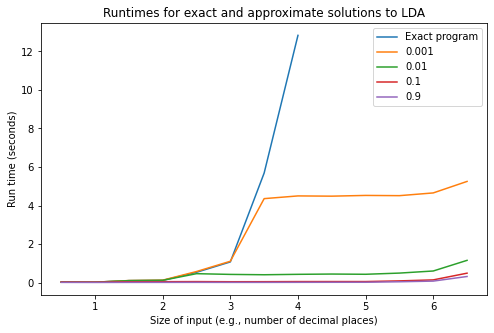

In [23]:
fig, ax = plt.subplots(figsize=[8,5])
list_of_programs = ["Exact program"]+epsilons
for eps in range(len(runtimes_df)):
    plt.plot(np.multiply(range(1,len(input_perturbation)+1),.5),runtimes_df.iloc[eps,:],label=list_of_programs[eps])
plt.legend()
#plt.yscale("symlog")
#plt.yscale('function', functions=(partial(np.power, 10.0), np.log10))

#plt.xscale("symlog")

plt.ylabel("Run time (seconds)")
plt.xlabel("Size of input (e.g., number of decimal places)")
plt.title("Runtimes for exact and approximate solutions to LDA")


Text(0.5, 1.0, '')

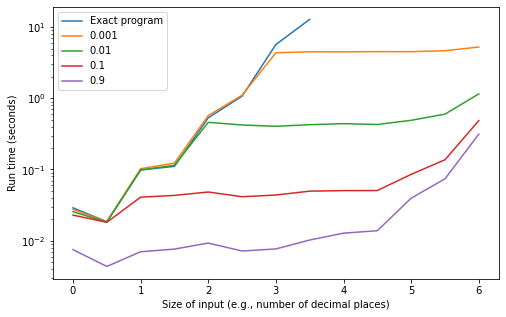

In [24]:
fig, ax = plt.subplots(figsize=[8,5])
list_of_programs = ["Exact program"]+epsilons
for eps in range(len(runtimes_df)):
    plt.plot(np.multiply(range(len(input_perturbation)),.5),runtimes_df.iloc[eps,:],label=list_of_programs[eps])
plt.legend()
plt.yscale("log")#, linthresh=0.015)
#plt.yscale('function', functions=(partial(np.power, 10.0), np.log10))

#plt.xscale("symlog")

plt.ylabel("Run time (seconds)")
plt.xlabel("Size of input (e.g., number of decimal places)")
plt.title("")

Text(0.5, 0, 'Length of input')

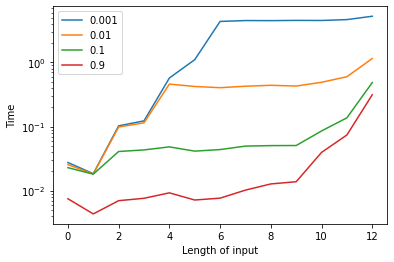

In [25]:
for eps in range(1,len(runtimes_df)):
    plt.plot(range(len(input_perturbation)),runtimes_df.iloc[eps,:],label=epsilons[eps-1])
plt.legend()
plt.yscale("log")
#plt.yscale('function', functions=(partial(np.power, 10.0), np.log10))

#plt.xscale("symlog")

plt.ylabel("Time")
plt.xlabel("Length of input")

In [26]:
solutions_df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,True,True,True,True,True,True,True,True,NaN,NaN,NaN,NaN,NaN
1,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True
4,False,False,False,False,False,False,False,False,False,False,False,False,False


# Empirical analysis for many randomly generated instances

In [12]:
def rho_approximations(epsilon,rho_1,rho_2,sigma,h_0,lamb):
    #First, do all the preliminary steps to find the range in disparity value
    u = 0.5*(rho_1+rho_2)*(sigma-lamb*(1-sigma))
    d = rho_1-rho_2
    h_opt = [1 if sigma[i]>(lamb/(1+lamb)) else 0 for i in range(len(sigma))]
    change_in_d_before_manip = d-2*(h_opt*d)
    print("change_in_d_before_manip: ",change_in_d_before_manip)
    change_in_u_before_manip = u-2*(h_opt*u)
    print("change_in_u_before_manip: ",change_in_u_before_manip)
    gcd = gcd_rational(np.abs(np.array(list(change_in_d_before_manip)+list(change_in_u_before_manip))))
    print("gcd in approx: ",gcd)
    change_in_d = np.array([int(round(i/gcd)) for i in change_in_d_before_manip])
    print("change_in_d: ",change_in_d)
    change_in_u = np.array([int(round(i/gcd)) for i in change_in_u_before_manip])#change_in_u/gcd
    print("change_in_u: ",change_in_u)
    U_h_0 = int(round(np.dot(u, h_0) / gcd))
    print("U_h_0: ",U_h_0)
    D_h_0 = int(round(np.dot(d, h_0)/gcd)) #D_h_0 = int(round(np.abs(np.dot(d, h_0))/gcd))
    print("D_h_0: ",D_h_0)
    U_h_opt = int(round(np.dot(u,h_opt) / gcd))
    D_h_opt = int(round(np.dot(d, h_opt)/gcd)) #D_h_opt = int(round(np.abs(np.dot(d, h_opt))/gcd))
    U_budget = U_h_opt-U_h_0
    print("U_budget: ",U_budget)
    n_data = len(h_0)
    print("n_data: ",n_data)
    max_change_in_d = D_h_opt
    min_change_in_d = D_h_opt
    for i in change_in_d:
        if i<0:
            min_change_in_d=min_change_in_d+i
        else:
            max_change_in_d = max_change_in_d+i
    d_range = list(range(min_change_in_d,max_change_in_d+1))
    print("length of d_range: ",len(d_range))

    #epsilon_manip = epsilon/len(d_range)
    #b = round((epsilon/(2*n_data))*len(d_range),12)
    b = round(epsilon/(2*n_data),12)
    print("b MANIP: ",b)

    rho_1_approx = np.ceil(np.divide(rho_1,b))*b#np.round(np.divide(rho_1,b))
    rho_2_approx = np.ceil(np.divide(rho_2,b))*b#np.round(np.divide(rho_2,b))
    print("rho_1: ", rho_1)
    print("rho_1_approx: ", rho_1_approx)
    print("rho_2: ", rho_2)
    print("rho_2_approx: ", rho_2_approx)
    
    return rho_1_approx,rho_2_approx

In [13]:
#n_options = 4
#max_decimals = 4
def generate_rho(n_options=4,max_decimals=3):
    randlist=[10**-(max_decimals-1)+random.random() for i in range(n_options-1)]
    rand_num_decimals = [int(np.floor(1+(random.random()*(max_decimals-1)))) for i in range(n_options-1)]
    for i in range(len(randlist)):
        randlist[i]=np.round(randlist[i],rand_num_decimals[i])
    #print("numerator: ",randlist)
    #print("denominator: ",np.ceil(np.sum(randlist)))
    if np.ceil(np.sum(randlist))>0:
        randlist=np.round(np.divide(randlist,np.ceil(np.sum(randlist))),max_decimals)
    else:
        randlist=np.round(np.divide(randlist,1+np.ceil(np.sum(randlist))),max_decimals)
    randlist = list(randlist) + [1-np.sum(randlist)]
    randlist = np.round(randlist,8)
    
    #If anything is 0, add max_decimal and 
    return np.array(randlist)

def generate_sigma(n_options=4,num_decimals=2):
    return np.array([np.round(random.random(),num_decimals) for i in range(n_options)])
    
#Random classifier
def generate_h_0_rand(n_options=4):
    return np.array([np.round(random.random()) for i in range(n_options)])


In [14]:
rho_1 = generate_rho(n_options=5,max_decimals=2)
rho_2 = generate_rho(n_options=5,max_decimals=2)
sigma = generate_sigma(n_options=5)
h_0 = generate_h_0_rand(n_options=5)
lamb = 1
print("rho_1: ",rho_1)
print("rho_2: ",rho_2)
print("sigma: ",sigma)
print("h_0: ",h_0)

#LDA(rho_1,rho_2,sigma,h_0,lamb)


numerator:  [0.1, 0.7, 0.4, 0.5]
denominator:  2.0
numerator:  [0.2, 1.1, 0.1, 0.1]
denominator:  2.0
rho_1:  [0.05 0.35 0.2  0.25 0.15]
rho_2:  [0.1  0.55 0.05 0.05 0.25]
sigma:  [0.9  0.33 0.95 0.75 0.45]
h_0:  [1. 1. 0. 1. 1.]


In [15]:
rho_approximations(.5,rho_1,rho_2,sigma,h_0,lamb)

change_in_d_before_manip:  [ 0.05 -0.2  -0.15 -0.2  -0.1 ]
change_in_u_before_manip:  [-0.06   -0.153  -0.1125 -0.075  -0.02  ]
gcd in approx:  0.0005
change_in_d:  [ 100 -400 -300 -400 -200]
change_in_u:  [-120 -306 -225 -150  -40]
U_h_0:  -76
D_h_0:  -300
U_budget:  571
n_data:  5
length of d_range:  1401
b MANIP:  0.05
rho_1:  [0.05 0.35 0.2  0.25 0.15]
rho_1_approx:  [0.05 0.35 0.2  0.25 0.15]
rho_2:  [0.1  0.55 0.05 0.05 0.25]
rho_2_approx:  [0.1  0.55 0.05 0.05 0.25]


(array([0.05, 0.35, 0.2 , 0.25, 0.15]), array([0.1 , 0.55, 0.05, 0.05, 0.25]))

In [16]:
LDA_approx(.01,rho_1,rho_2,sigma,h_0,lamb)

change_in_d_before_manip:  [ 0.05 -0.2  -0.15 -0.2  -0.1 ]
change_in_u_before_manip:  [-0.06   -0.153  -0.1125 -0.075  -0.02  ]
gcd in approx:  0.0005
change_in_d:  [ 100 -400 -300 -400 -200]
change_in_u:  [-120 -306 -225 -150  -40]
U_h_0:  -76
D_h_0:  -300
U_budget:  571
n_data:  5
length of d_range:  1401
b MANIP:  0.001
rho_1:  [0.05 0.35 0.2  0.25 0.15]
rho_1_approx:  [0.05 0.35 0.2  0.25 0.15]
rho_2:  [0.1  0.55 0.05 0.05 0.25]
rho_2_approx:  [0.1  0.55 0.05 0.05 0.25]
gcd:  0.0005
[0.05 0.35 0.2  0.25 0.15]
[0.1  0.55 0.05 0.05 0.25]
[-0.05 -0.2   0.15  0.2  -0.1 ]
[1. 1. 0. 1. 1.]
0.0005
D_h_0:  -300
NOTE: Starting disparity negative. Value of D_h_0:  -300
LDA disparity performance before rebase:  200
LDA utility performance before rebase:  40.0


array([1, 0, 1, 1, 1])

In [17]:
epsilons = [0.01,0.1,.5]#[0.001,0.01,0.1,.9]
maxrows= 10000
colnames = ['n_options','total_size_of_input','max_decimals','true_solution','LDA_exists_certificate','full_runtime','solution_memory']
for e in epsilons:
    colnames = colnames + [str(e)+'approximation_runtime']
    colnames = colnames + [str(e)+'approximation_accuracy']
    colnames = colnames + [str(e)+'approximation_memory']
    
print(colnames)
simulation_results_df = pd.DataFrame({c:[-1]*maxrows for c in colnames})


['n_options', 'total_size_of_input', 'max_decimals', 'true_solution', 'LDA_exists_certificate', 'full_runtime', 'solution_memory', '0.01approximation_runtime', '0.01approximation_accuracy', '0.01approximation_memory', '0.1approximation_runtime', '0.1approximation_accuracy', '0.1approximation_memory', '0.5approximation_runtime', '0.5approximation_accuracy', '0.5approximation_memory']


In [520]:
# Create a dataframe to track progress
#simulation_results_df = pd.DataFrame({c:[-1]*maxrows for c in colnames})

#rowindex = 0
rowindex

383

In [533]:
#Go through some examples
num_runs = 1
#num_datapoints_min = 2
#num_datapoints_max = 6
num_datapoints_list = [4,5]#[2,4,5]#,8,10]
max_decimals_min = 1
max_decimals_max = 5

for n in num_datapoints_list:#range(num_datapoints_min,num_datapoints_max,2):
    print()
    print("n: ",n)
    for max_d in range(max_decimals_min,max_decimals_max):
        print()
        print("max_decimals: ",max_d)
        for j in range(num_runs):
            #Set up problem instance
            rho_1 = generate_rho(n_options=n,max_decimals=max_d)
            rho_2 = generate_rho(n_options=n,max_decimals=max_d)
            sigma = generate_sigma(n_options=n)
            h_0 = generate_h_0_rand(n_options=n)
            print("rho_1: ",rho_1)
            print("rho_2: ",rho_2)
            print("sigma: ",sigma)
            print("h_0: ",h_0)
            
            #Fill in values
            simulation_results_df.loc[rowindex,'n_options']=n
            n_total_decimals= 0 
            for num in list(list(rho_1)+list(rho_2)+list(sigma)):
                n_total_decimals = n_total_decimals + len(str(num).split('.')[1])
            print("n_total_decimals: ",n_total_decimals)
            simulation_results_df.loc[rowindex,'total_size_of_input']=n_total_decimals
            simulation_results_df.loc[rowindex,'max_decimals']=max_d
            
            #Solve the problem
            memory_start = psutil.Process().memory_info().rss / 1024**2
            LDA_start = time.time()
            true_solution = LDA(rho_1,rho_2,sigma,h_0,lamb)
            simulation_results_df.loc[rowindex,'true_solution'] = str(true_solution)
            LDA_end = time.time()
            memory_end = psutil.Process().memory_info().rss / 1024**2
            print("true_solution: ",str(true_solution))
            simulation_results_df.loc[rowindex,'full_runtime'] = LDA_end - LDA_start
            simulation_results_df.loc[rowindex,'solution_memory'] = memory_end - memory_start
            print("full_runtime: ",simulation_results_df.loc[rowindex,'full_runtime'])
            print("solution_memory: ",simulation_results_df.loc[rowindex,'solution_memory'])
            simulation_results_df.loc[rowindex,'LDA_exists_certificate']=np.alltrue(true_solution==h_0)
            
            #Solve for different values of epsilon
            for e in epsilons:
                print()
                print("e: ",e)
                memory_start = psutil.Process().memory_info().rss / 1024**2
                LDA_start = time.time()
                simulation_results_df.loc[rowindex,str(e)+'approximation_accuracy'] = np.alltrue(LDA_approx(e,rho_1,rho_2,sigma,h_0,lamb)==true_solution)
                LDA_end = time.time()
                memory_end = psutil.Process().memory_info().rss / 1024**2
                simulation_results_df.loc[rowindex,str(e)+'approximation_runtime'] = LDA_end-LDA_start
                simulation_results_df.loc[rowindex,str(e)+'approximation_memory'] = memory_end-memory_start

            rowindex=rowindex+1


n:  4

max_decimals:  1
numerator:  [1.8, 1.6, 1.8]
denominator:  6.0
numerator:  [1.1, 1.0, 1.7]
denominator:  4.0
rho_1:  [0.3 0.3 0.3 0.1]
rho_2:  [0.3 0.2 0.4 0.1]
sigma:  [0.72 0.45 0.24 0.4 ]
h_0:  [0. 0. 0. 1.]
n_total_decimals:  15
gcd:  0.001
[0.3 0.3 0.3 0.1]
[0.3 0.2 0.4 0.1]
[ 0.   0.1 -0.1  0. ]
[0. 0. 0. 1.]
0.001
D_h_0:  0
NOTE: Starting disparity of 0. Value of D_h_0:  0
NO LDA EXISTS.
true_solution:  [0. 0. 0. 1.]
full_runtime:  0.08561205863952637
solution_memory:  5.41796875

e:  0.01
change_in_d_before_manip:  [ 0.   0.1 -0.1  0. ]
change_in_u_before_manip:  [-0.132 -0.025 -0.182 -0.02 ]
gcd in approx:  0.001
change_in_d:  [   0  100 -100    0]
change_in_u:  [-132  -25 -182  -20]
U_h_0:  -20
D_h_0:  0
U_budget:  152
n_data:  4
length of d_range:  201
b MANIP:  0.00125
rho_1:  [0.3 0.3 0.3 0.1]
rho_1_approx:  [0.3 0.3 0.3 0.1]
rho_2:  [0.3 0.2 0.4 0.1]
rho_2_approx:  [0.3 0.2 0.4 0.1]
gcd:  0.001
[0.3 0.3 0.3 0.1]
[0.3 0.2 0.4 0.1]
[ 0.   0.1 -0.1  0. ]
[0. 0. 0. 1.

LDA disparity performance before rebase:  500
LDA utility performance before rebase:  3366.0

e:  0.1
change_in_d_before_manip:  [-0.09   0.261  0.079  0.092]
change_in_u_before_manip:  [-0.0836  -0.19741  0.      -0.1974 ]
gcd in approx:  1e-05
change_in_d:  [-9000 26100  7900  9200]
change_in_u:  [ -8360 -19741      0 -19740]
U_h_0:  8360
D_h_0:  16900
U_budget:  19741
n_data:  4
length of d_range:  52201
b MANIP:  0.0125
rho_1:  [0.14  0.389 0.19  0.281]
rho_1_approx:  [0.15   0.4    0.2    0.2875]
rho_2:  [0.05  0.65  0.111 0.189]
rho_2_approx:  [0.05   0.65   0.1125 0.2   ]
gcd:  0.00025
[0.15   0.4    0.2    0.2875]
[0.05   0.65   0.1125 0.2   ]
[ 0.1    -0.25    0.0875  0.0875]
[1. 0. 1. 0.]
0.00025
D_h_0:  750
LDA disparity performance before rebase:  50
LDA utility performance before rebase:  352.0

e:  0.5
change_in_d_before_manip:  [-0.09   0.261  0.079  0.092]
change_in_u_before_manip:  [-0.0836  -0.19741  0.      -0.1974 ]
gcd in approx:  1e-05
change_in_d:  [-9000 26100  

LDA disparity performance before rebase:  100
LDA utility performance before rebase:  777.0

e:  0.5
change_in_d_before_manip:  [ 0.1   -0.017 -0.158  0.253  0.212]
change_in_u_before_manip:  [-0.126   -0.07511 -0.08932 -0.12383 -0.03258]
gcd in approx:  1e-05
change_in_d:  [ 10000  -1700 -15800  25300  21200]
change_in_u:  [-12600  -7511  -8932 -12383  -3258]
U_h_0:  -5089
D_h_0:  11700
U_budget:  15858
n_data:  5
length of d_range:  74001
b MANIP:  0.05
rho_1:  [0.4   0.11  0.075 0.34  0.075]
rho_1_approx:  [0.4  0.15 0.1  0.35 0.1 ]
rho_2:  [0.3   0.093 0.233 0.087 0.287]
rho_2_approx:  [0.3  0.1  0.25 0.1  0.3 ]
gcd:  0.0005
[0.4  0.15 0.1  0.35 0.1 ]
[0.3  0.1  0.25 0.1  0.3 ]
[ 0.1   0.05 -0.15  0.25 -0.2 ]
[1. 1. 0. 0. 0.]
0.0005
D_h_0:  300
LDA disparity performance before rebase:  100
LDA utility performance before rebase:  185.0

max_decimals:  4
numerator:  [0.115, 0.1, 0.517, 0.3]
denominator:  2.0
numerator:  [0.738, 0.5, 0.57, 0.51]
denominator:  3.0
rho_1:  [0.0575 0.05 

(5.0, 50.0)

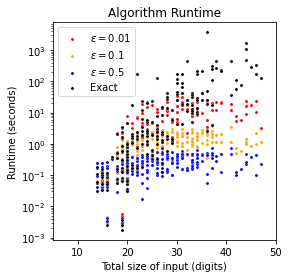

In [534]:
import seaborn as sns

fig, ax=plt.subplots(figsize=[4,4])
sns.scatterplot(data=simulation_results_df[(simulation_results_df['n_options']>3)&#(simulation_results_df['total_size_of_input']>0)
                                           (simulation_results_df['n_options']<6)#&(simulation_results_df['total_size_of_input']<50)
                                           #&(simulation_results_df['max_decimals']==4)
                                          ]
                ,x='total_size_of_input',y='0.01approximation_runtime',color='red',s=10,label='$\epsilon=0.01$')
sns.scatterplot(data=simulation_results_df[(simulation_results_df['n_options']>3)&#(simulation_results_df['total_size_of_input']>0)
                                           (simulation_results_df['n_options']<6)#&(simulation_results_df['total_size_of_input']<50)
                                           #&(simulation_results_df['max_decimals']==4)
                                          ]
                ,x='total_size_of_input',y='0.1approximation_runtime',color='orange',s=10,label='$\epsilon=0.1$')
sns.scatterplot(data=simulation_results_df[(simulation_results_df['n_options']>3)&#(simulation_results_df['total_size_of_input']>0)
                                           (simulation_results_df['n_options']<6)#&(simulation_results_df['total_size_of_input']<50)
                                           #&(simulation_results_df['max_decimals']==4)
                                          ]
                ,x='total_size_of_input',y='0.5approximation_runtime',color='blue',s=10,label='$\epsilon=0.5$')
sns.scatterplot(data=simulation_results_df[(simulation_results_df['n_options']>3)&#(simulation_results_df['total_size_of_input']>0)
                                           (simulation_results_df['n_options']<6)#&(simulation_results_df['total_size_of_input']<50)
                                           #&(simulation_results_df['max_decimals']==4)
                                          ]
                ,x='total_size_of_input',y='full_runtime',color='black',s=10,label='Exact')
plt.legend()
plt.ylabel("Runtime (seconds)")
plt.xlabel("Total size of input (digits)")
plt.title('Algorithm Runtime')
plt.yscale('log')
plt.xlim([5,50])
#plt.xscale(.'log')

In [535]:
print(len(simulation_results_df[(simulation_results_df['n_options']>3)#(simulation_results_df['total_size_of_input']>15)
                                           &(simulation_results_df['n_options']<6)#&(simulation_results_df['total_size_of_input']<50)
                                           #&(simulation_results_df['max_decimals']==4)
                     ]
                  ))


250


250


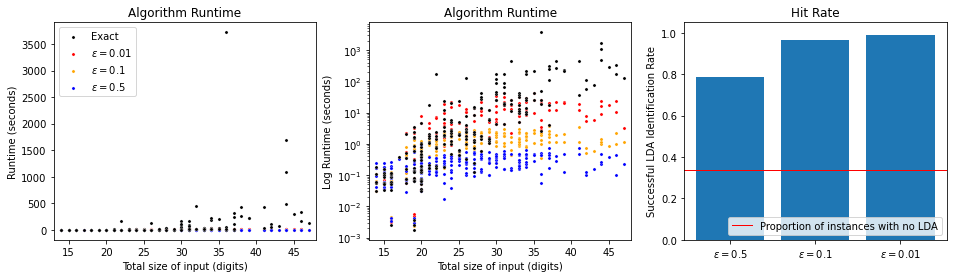

In [536]:
fig = plt.figure(figsize=[16,4])

ax = fig.add_subplot(1, 3, 1)

sns.scatterplot(data=simulation_results_df[(simulation_results_df['n_options']>3)&##(simulation_results_df['total_size_of_input']>0)
                                           (simulation_results_df['n_options']<6)#&(simulation_results_df['total_size_of_input']<50)
                                           #&(simulation_results_df['max_decimals']==4)
                                          ]
                ,x='total_size_of_input',y='full_runtime',color='black',s=10,label='Exact',zorder=1.1)
sns.scatterplot(data=simulation_results_df[(simulation_results_df['n_options']>3)&##(simulation_results_df['total_size_of_input']>0)
                                           (simulation_results_df['n_options']<6)#&(simulation_results_df['total_size_of_input']<50)
                                           #&(simulation_results_df['max_decimals']==4)
                                          ]
                ,x='total_size_of_input',y='0.01approximation_runtime',color='red',s=10,label='$\epsilon=0.01$')
sns.scatterplot(data=simulation_results_df[(simulation_results_df['n_options']>3)&##(simulation_results_df['total_size_of_input']>0)
                                           (simulation_results_df['n_options']<6)#&(simulation_results_df['total_size_of_input']<50)
                                           #&(simulation_results_df['max_decimals']==4)
                                          ]
                ,x='total_size_of_input',y='0.1approximation_runtime',color='orange',s=10,label='$\epsilon=0.1$')
sns.scatterplot(data=simulation_results_df[(simulation_results_df['n_options']>3)&##(simulation_results_df['total_size_of_input']>0)
                                           (simulation_results_df['n_options']<6)#&(simulation_results_df['total_size_of_input']<50)
                                           #&(simulation_results_df['max_decimals']==4)
                                          ]
                ,x='total_size_of_input',y='0.5approximation_runtime',color='blue',s=10,label='$\epsilon=0.5$')

plt.legend(loc='upper left')
plt.ylabel("Runtime (seconds)")
plt.xlabel("Total size of input (digits)")
plt.title('Algorithm Runtime')
plt.xlim([13,48])

ax = fig.add_subplot(1, 3, 2)

sns.scatterplot(data=simulation_results_df[(simulation_results_df['n_options']>3)&##(simulation_results_df['total_size_of_input']>0)
                                           (simulation_results_df['n_options']<6)#&(simulation_results_df['total_size_of_input']<50)
                                           #&(simulation_results_df['max_decimals']==4)
                                          ]
                ,x='total_size_of_input',y='full_runtime',color='black',s=10,label='Exact',zorder=1.1)
sns.scatterplot(data=simulation_results_df[(simulation_results_df['n_options']>3)&##(simulation_results_df['total_size_of_input']>0)
                                           (simulation_results_df['n_options']<6)#&(simulation_results_df['total_size_of_input']<50)
                                           #&(simulation_results_df['max_decimals']==4)
                                          ]
                ,x='total_size_of_input',y='0.01approximation_runtime',color='red',s=10,label='$\epsilon=0.01$')

sns.scatterplot(data=simulation_results_df[(simulation_results_df['n_options']>3)&##(simulation_results_df['total_size_of_input']>0)
                                           (simulation_results_df['n_options']<6)#&(simulation_results_df['total_size_of_input']<50)
                                           #&(simulation_results_df['max_decimals']==4)
                                          ]
                ,x='total_size_of_input',y='0.1approximation_runtime',color='orange',s=10,label='$\epsilon=0.1$')

sns.scatterplot(data=simulation_results_df[(simulation_results_df['n_options']>3)&##(simulation_results_df['total_size_of_input']>0)
                                           (simulation_results_df['n_options']<6)#&(simulation_results_df['total_size_of_input']<50)
                                           #&(simulation_results_df['max_decimals']==4)
                                          ]
                ,x='total_size_of_input',y='0.5approximation_runtime',color='blue',s=10,label='$\epsilon=0.5$')

plt.legend().remove()
plt.ylabel("Log Runtime (seconds)")
plt.xlabel("Total size of input (digits)")
plt.title('Algorithm Runtime')
plt.yscale('log')
plt.xlim([13,48])

#PLOT 3
ax = fig.add_subplot(1, 3, 3)

len_of_tests = len(simulation_results_df[(simulation_results_df['n_options']>3)&#(simulation_results_df['total_size_of_input']>15)
                                           (simulation_results_df['n_options']<6)#&(simulation_results_df['total_size_of_input']<50)
                                           #&(simulation_results_df['max_decimals']==4)
                     ]
                  )
num_accurate = (simulation_results_df[(simulation_results_df['n_options']>3)&#(simulation_results_df['total_size_of_input']>15)
                                           (simulation_results_df['n_options']<6)#&(simulation_results_df['total_size_of_input']<50)
                                           #&(simulation_results_df['max_decimals']==4)
                     ]
                [['0.5approximation_accuracy','0.1approximation_accuracy','0.01approximation_accuracy']].astype(float).sum()
               )
plt.bar(x=['$\epsilon=0.5$','$\epsilon=0.1$','$\epsilon=0.01$'],height=list(num_accurate/len_of_tests))
plt.axhline(y=min(LDA_existence_rate_info)/sum(LDA_existence_rate_info),linewidth=1, color='r',label='Proportion of instances with no LDA')
plt.legend(loc='lower right')
plt.title('Hit Rate')
plt.ylabel('Successful LDA Identification Rate')

plt.ylim([0,1.05])


LDA_existence_rate_info = simulation_results_df[(simulation_results_df['n_options']>3)&#(simulation_results_df['total_size_of_input']>15)
                                           (simulation_results_df['n_options']<6)#&(simulation_results_df['total_size_of_input']<50)
                                           #&(simulation_results_df['max_decimals']==4)
                     ]['LDA_exists_certificate'].value_counts()
plt.savefig('LDA-FPTAS-figure.png',dpi=300)

print(len_of_tests)

In [538]:
simulation_results_df[(simulation_results_df['n_options']>3)&#(simulation_results_df['total_size_of_input']>15)
                                           (simulation_results_df['n_options']<6)#&(simulation_results_df['total_size_of_input']<50)
                                           #&(simulation_results_df['max_decimals']==4)
                     ]['LDA_exists_certificate'].value_counts()

True     164
False     86
Name: LDA_exists_certificate, dtype: int64

In [526]:
num_accurate/len_of_tests

0.5approximation_accuracy     0.785124
0.1approximation_accuracy     0.966942
0.01approximation_accuracy    0.987603
dtype: float64

In [527]:
num_accurate/len_of_tests

0.5approximation_accuracy     0.785124
0.1approximation_accuracy     0.966942
0.01approximation_accuracy    0.987603
dtype: float64

Text(0.5, 0, 'Total size of input (digits)')

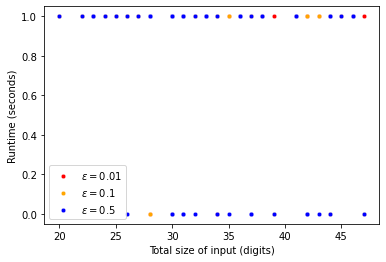

In [528]:
sns.scatterplot(data=simulation_results_df[(simulation_results_df['total_size_of_input']>15)
                                           &(simulation_results_df['n_options']<6)#&(simulation_results_df['total_size_of_input']<50)
                                           &(simulation_results_df['max_decimals']==4)
                                          ],x='total_size_of_input',y='0.01approximation_accuracy',color='red',s=20,label='$\epsilon=0.01$')
sns.scatterplot(data=simulation_results_df[(simulation_results_df['total_size_of_input']>15)
                                           &(simulation_results_df['n_options']<6)#&(simulation_results_df['total_size_of_input']<50)
                                           &(simulation_results_df['max_decimals']==4)
                                          ],x='total_size_of_input',y='0.1approximation_accuracy',color='orange',s=20,label='$\epsilon=0.1$')
sns.scatterplot(data=simulation_results_df[(simulation_results_df['total_size_of_input']>15)
                                           &(simulation_results_df['n_options']<6)#&(simulation_results_df['total_size_of_input']<50)
                                           &(simulation_results_df['max_decimals']==4)
                                          ],x='total_size_of_input',y='0.5approximation_accuracy',color='blue',s=20,label='$\epsilon=0.5$')

plt.legend()
plt.ylabel("Runtime (seconds)")
plt.xlabel("Total size of input (digits)")

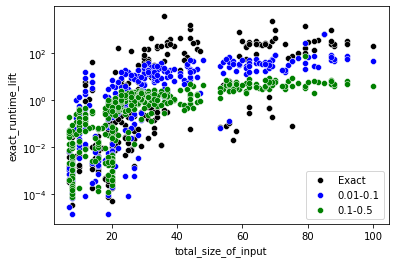

In [529]:
simulation_results_df['exact_runtime_lift'] = simulation_results_df['full_runtime']-simulation_results_df['0.01approximation_runtime']
simulation_results_df['01_runtime_lift'] = simulation_results_df['0.01approximation_runtime']-simulation_results_df['0.1approximation_runtime']
simulation_results_df['1_runtime_lift'] = simulation_results_df['0.1approximation_runtime']-simulation_results_df['0.5approximation_runtime']

sns.scatterplot(data=simulation_results_df[simulation_results_df['total_size_of_input']>0],x='total_size_of_input',y='exact_runtime_lift',color='black',label='Exact')
sns.scatterplot(data=simulation_results_df[simulation_results_df['total_size_of_input']>0],x='total_size_of_input',y='01_runtime_lift',color='blue',label='0.01-0.1')
sns.scatterplot(data=simulation_results_df[simulation_results_df['total_size_of_input']>0],x='total_size_of_input',y='1_runtime_lift',color='green',label='0.1-0.5')

plt.yscale('log')

In [530]:
simulation_results_df['exact_runtime_lift'][:25]

0       0.000339
1      -1.757903
2     153.909952
3      33.794399
4      22.162556
5       0.501018
6     244.123772
7     302.746105
8     317.586281
9     212.231981
10     -0.048351
11      2.684625
12     44.284876
13      5.366853
14     19.966763
15      9.371772
16    414.593229
17     19.640982
18     54.372233
19     96.248957
20    211.986005
21    195.844206
22    238.146621
23    208.858807
24     77.427456
Name: exact_runtime_lift, dtype: float64

In [531]:
simulation_results_df.to_csv('polynomial-time-results.csv')

Text(0, 0.5, 'Memory (MiB)')

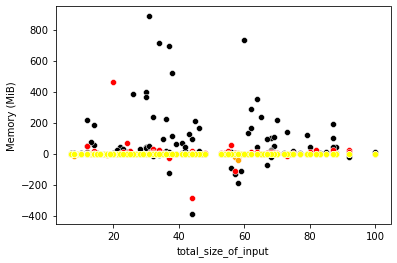

In [532]:
sns.scatterplot(data=simulation_results_df[simulation_results_df['total_size_of_input']>0],x='total_size_of_input',y='solution_memory',color='black')
sns.scatterplot(data=simulation_results_df[simulation_results_df['total_size_of_input']>0],x='total_size_of_input',y='0.01approximation_memory',color='red')
sns.scatterplot(data=simulation_results_df[simulation_results_df['total_size_of_input']>0],x='total_size_of_input',y='0.1approximation_memory',color='orange')
sns.scatterplot(data=simulation_results_df[simulation_results_df['total_size_of_input']>0],x='total_size_of_input',y='0.5approximation_memory',color='yellow')

plt.ylabel("Memory (MiB)")


In [27]:
simulation_results_df['0.01approximation_accuracy'].value_counts()#[simulation_results_df['0.01approximation_runtime']>20]


-1      9990
True      10
Name: 0.01approximation_accuracy, dtype: int64

In [197]:
simulation_results_df[:15]

,n_options,total_size_of_input,max_decimals,true_solution,LDA_exists_certificate,full_runtime,solution_memory,0.01approximation_runtime,0.01approximation_accuracy,0.01approximation_memory,0.1approximation_runtime,0.1approximation_accuracy,0.1approximation_memory,0.5approximation_runtime,0.5approximation_accuracy,0.5approximation_memory,exact_runtime_lift,01_runtime_lift,1_runtime_lift
0,2,7,4,[1. 0.],True,0.013392,1.148438,0.013053,True,0.855469,0.014548,True,0.015625,0.012443,True,0.003906,0.000339,-0.001495,0.002105
1,2,12,4,[0. 1.],True,7.934654,46.972656,9.692557,True,47.136719,0.545037,True,0.023438,0.057513,True,0.000000,-1.757903,9.147520,0.487524
2,4,31,4,[1. 0. 0. 0.],True,167.378264,886.531250,13.468312,True,0.792969,0.390763,True,0.007812,0.154301,True,0.003906,153.909952,13.077549,0.236462
3,4,30,4,[1 0 1 0],False,40.091848,2.394531,6.297449,True,0.039062,1.217100,True,0.039062,0.302434,False,0.000000,33.794399,5.080349,0.914666
4,5,33,4,[1 1 1 1 1],False,43.146995,0.050781,20.984439,True,0.000000,2.199175,True,0.003906,0.440716,True,0.039062,22.162556,18.785264,1.758459
5,5,31,4,[1. 0. 0. 1. 0.],True,17.358182,1.519531,16.857164,True,0.167969,0.831708,True,0.000000,0.160273,True,0.000000,0.501018,16.025456,0.671435
6,8,73,4,[1 0 0 1 1 0 1 0],False,263.810207,141.789062,19.686435,True,0.000000,3.844280,True,0.003906,0.761732,False,-0.003906,244.123772,15.842155,3.082548
7,8,62,4,[1 1 1 1 1 1 1 0],False,361.205778,290.019531,58.459673,True,8.363281,5.797594,True,0.003906,1.130234,False,0.015625,302.746105,52.662079,4.667360
8,10,92,4,[0 0 0 0 0 1 0 1 0 0],False,398.771521,-11.843750,81.185240,True,25.402344,8.214904,False,0.000000,1.752531,False,0.093750,317.586281,72.970336,6.462373
9,10,88,4,[1 1 0 1 0 0 0 1 1 1],False,263.816893,45.914062,51.584912,True,0.003906,5.184240,True,0.003906,0.986522,False,0.000000,212.231981,46.400672,4.197718


## Misc/other

Here we try measuring memory, among other things

In [22]:
rho_1 = generate_rho(n_options=4,max_decimals=3)
rho_2 = generate_rho(n_options=4,max_decimals=3)
sigma = generate_sigma(n_options=4)
h_0 = generate_h_0_rand(n_options=4)
lamb = 1



numerator:  [0.56, 0.52, 0.35]
denominator:  2.0
numerator:  [0.41, 0.2, 0.46]
denominator:  2.0


In [25]:
#tracemalloc.start()
import psutil

start = time.time()
memory_start = psutil.Process().memory_info().rss / 1024**2

print("TIME START: ", start)
print("MEMORY START: ",psutil.Process().memory_info().rss / 1024**2)

LDA(rho_1,rho_2,sigma,h_0,lamb)

end = time.time()
memory_end = psutil.Process().memory_info().rss / 1024**2
print("TIME end: ", end)
print("MEMORY END: ",psutil.Process().memory_info().rss / 1024**2)


#tracemalloc.stop()

TIME START:  1725731875.411242
MEMORY START:  146.02734375
gcd:  5e-05
[0.28  0.26  0.175 0.285]
[0.205 0.1   0.23  0.465]
[ 0.075  0.16  -0.055 -0.18 ]
[0. 0. 1. 1.]
5e-05
D_h_0:  -4700
NOTE: Starting disparity negative. Value of D_h_0:  -4700
NO LDA EXISTS.
TIME end:  1725731878.19204
MEMORY END:  146.55078125


In [201]:
epsilons = [0.001,0.01,0.1,.9]
colnames = ['n_options','total_size_of_input','max_decimals','true_solution','full_runtime']
for e in epsilons:
    colnames = colnames + [str(e)+'approximation']
    
print(colnames)
simulation_results_df = pd.DataFrame({c:[-1]*10000 for c in colnames})

#simulation_results_df.iloc[0,1]
simulation_results_df

['n_options', 'total_size_of_input', 'max_decimals', 'true_solution', 'full_runtime', '0.001approximation', '0.01approximation', '0.1approximation', '0.9approximation']


,n_options,total_size_of_input,max_decimals,true_solution,full_runtime,0.001approximation,0.01approximation,0.1approximation,0.9approximation
0,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...
9995,-1,-1,-1,-1,-1,-1,-1,-1,-1
9996,-1,-1,-1,-1,-1,-1,-1,-1,-1
9997,-1,-1,-1,-1,-1,-1,-1,-1,-1
9998,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [202]:
for i in range(-10):
    print(i)

In [302]:
simulation_results_df

,n_options,total_size_of_input,max_decimals


In [281]:
rand_num_decimals

[1, 1, 3, 2]